In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import seaborn as sns

import pmagpy.ipmag as ipmag

from scripts.auxiliar import get_files_in_directory, GCD_cartesian

In [2]:
def spherical2cartesian(v):
    """
    v[0] = theta - Latitude
    v[1] = phi - Longitude
    """
    
    x = np.cos(v[0]) * np.cos(v[1])  
    y = np.cos(v[0]) * np.sin(v[1])  
    z = np.sin(v[0])  
    
    return [x,y,z]

def cartesian2spherical(v):  
    """
    Take an array of lenght 3 correspoingt to a 3-dimensional vector and returns a array of lenght 2
    with latitade (inclination) and longitude (declination)
    """
    theta = np.arcsin(v[2]) 
    phi = np.arctan2(v[1], v[0])
        
    return [theta, phi]

In [3]:
current_path = os.getcwd() 
data_path = current_path + '/data'
data_path_PP = data_path + "/poles_NAM"

In [4]:
data_path_VGP = current_path + "/data/VGPs_NAM"

# this reads the names of all the files in the data path foldel we have
files_names = get_files_in_directory(data_path_VGP)

In [5]:
current_path = os.getcwd() 
data_path = current_path + '/data'
data_path_PP = data_path + "/poles_NAM"
file_name = "/NAM_poles_0_130_pole_id.xlsx"
df_NAM = pd.read_excel(data_path_PP + file_name)

In [16]:
dfs = []
poles = []

for fname in files_names:      
    
    df_tmp = pd.read_excel(fname, skiprows = 5)
    
    df_tmp.insert(0, 'pole_id', fname.replace('.', '/').replace('\\', '/').split('/')[-2])
    df_tmp.insert(1, 'vgp_id', np.arange(1, df_tmp.shape[0] + 1))
    
    # Calculates Pole statistics from vgps   
    ipmag.vgp_calc(df_tmp, site_lon='slon', site_lat='slat', dec_tc='dec', inc_tc='inc')
    
    #CRITERIA: if there is no slat/slon in the paper, we get as 'true' the VGP reported in the paper
    df_tmp.vgp_lat.fillna(df_tmp.VGP_lat, inplace=True)
    df_tmp.vgp_lon.fillna(df_tmp.VGP_lon, inplace=True)
        
    df_tmp['vgp_lat_SH'] = np.where(df_tmp['vgp_lat'] > 0, -df_tmp['vgp_lat'], df_tmp['vgp_lat'])
    df_tmp['vgp_lon_SH'] = np.where(df_tmp['vgp_lat'] > 0,(df_tmp['vgp_lon'] - 180.) % 360., df_tmp['vgp_lon'])
     
    #CALCULATES FISHER STATISTICS FROM THE VGP LEVEL    
    mean_tmp = ipmag.fisher_mean(dec = df_tmp['vgp_lon_SH'].tolist(),inc = df_tmp['vgp_lat_SH'].tolist())
    mean_tmp['pole_id'] = fname.replace('.', '/').replace('\\', '/').split('/')[-2]
    
    poles.append(mean_tmp)    
    dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)
poles_from_vgps = pd.DataFrame(poles, index=df['pole_id'].unique().tolist())

In [17]:
poles_from_vgps

,dec,inc,n,r,k,alpha95,csd,pole_id
1,40.743341,-86.048205,45,42.609202,18.403900,5.096357,18.881221,1
10,267.711248,-88.340153,17,16.623349,42.479588,5.536743,12.427818,10
11,239.148090,-67.077683,23,14.859409,2.702506,23.061779,49.272166,11
12,275.512791,-71.976300,51,40.258736,4.654946,10.414476,37.542891,12
13,25.393571,-84.827136,24,21.858915,10.742219,9.469288,24.713714,13
14,263.158239,-65.974838,62,39.321520,2.689775,13.839686,49.388640,14
16,269.598821,-76.433320,30,27.780393,13.065378,7.561126,22.409080,16
17,114.947969,-80.327988,10,9.338902,13.613722,13.580354,21.953136,17
18,352.284567,-78.608970,25,23.293661,14.065203,8.002832,21.597924,18
19,21.143330,-63.593328,23,19.862668,7.012329,12.323351,30.588198,19


In [18]:
df_NAM

,pole_id,name,min_age,max_age,age,slat,slon,N,k,alpha95,...,lithology,Rlat,Rlon,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints
0,1,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,...,volcanic,-86.3,5.7,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron
1,2,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,...,volcanic,-86.4,9.2,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study)
2,3,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,...,volcanic,-85.3,-94.1,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...
3,4,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,...,volcanic,-88.9,-75.1,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated)
4,5,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,...,clastics,-80.0,4.2,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61,Tatnic Complex,120.0,124.0,122.0,43.30,289.30,10,113.0,4.6,...,plutonic,-44.4,86.2,65.7,-19.8,55.3,McEnroe (1996b),5,"high-T CHRM, exsolution lamellae and fine reac...","122±2; K-Ar on biotite in gabbro, Ar-Ar on bio..."
61,62,Monteregian Hills intrusives,117.0,127.0,122.0,45.30,286.80,70,49.2,2.4,...,plutonic,-51.7,79.7,65.7,-19.8,55.3,Foster and Symons (1979),6,NaN,118±4 Ma Rb-Sr; 123±4 K-Ar
62,63,White Mountains igneous complex,119.0,126.0,122.5,43.50,288.30,8,274.9,3.3,...,plutonic,-51.5,77.6,65.7,-19.8,55.3,Van Fossen and Kent (1992),5,NaN,Ar/Ar age of 122.5±3.5
63,64,Lebanon diorite,122.0,128.0,125.0,43.40,289.20,5,113.0,7.5,...,plutonic,-49.4,83.7,65.4,-18.9,56.8,McEnroe (1996b),5,"high-T CHRM, exsolution lamellae and fine reac...",125±3 Ma K-Ar on biotite. They discarded disco...


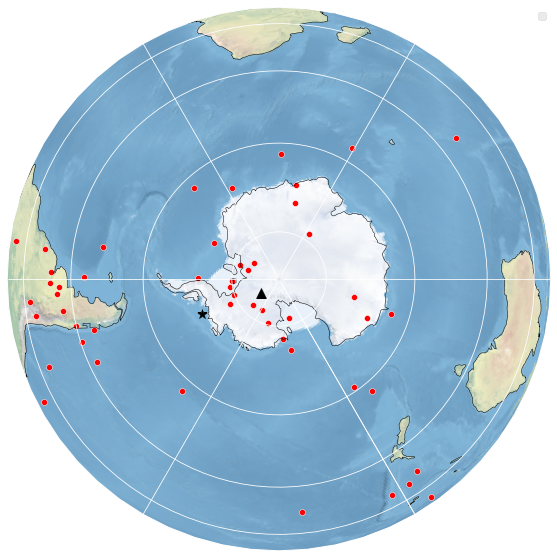

In [24]:
pole_id = 12

pole_vgps = poles_from_vgps[poles_from_vgps['pole_id'] == str(pole_id)]
vgps = df[df['pole_id'] == str(pole_id)]
pole_reference = df_NAM[df_NAM['pole_id'] == pole_id]

fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -90)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = vgps['vgp_lon_SH'], y = vgps['vgp_lat_SH'],
                color = "red",                
                transform = ccrs.PlateCarree())

plt.scatter(x =pole_vgps['dec'], y = pole_vgps['inc'], marker ="*", 
            s = 100, color = "black", 
            transform = ccrs.PlateCarree())

plt.scatter(x =pole_reference['plon'], y = pole_reference['plat'], marker ="^", 
            s = 100, color = "black", 
            transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

In [10]:
GCDs = []
ID = []
for _, i in poles_from_vgps.iterrows():
        
    pole_vgps = poles_from_vgps[poles_from_vgps['pole_id'] == str(i.pole_id)]
    pole_reference = df_NAM[df_NAM['pole_id'] == int(i.pole_id)]
    
    
    cart_ref = (spherical2cartesian([np.radians(pole_reference['plat'].values)[0],np.radians(pole_reference['plon'].values)[0]]))
    cart_vgps = (spherical2cartesian([np.radians(pole_vgps['inc'].values)[0], np.radians(pole_vgps['dec'].values)[0]]))
    
    GCDs.append(GCD_cartesian(cart_ref,cart_vgps)*180/np.pi)
    ID.append(int(i.pole_id))
    
dictionary = {'id':ID, 'gcds': GCDs}
df = pd.DataFrame(dictionary)

df
# fig = plt.figure(figsize=(15,5))
# plt.scatter(ID, GCDs)
# plt.show()

,id,gcds
0,1,2.314633
1,10,0.514576
2,11,21.117819
3,12,13.494551
4,13,1.179240
5,14,19.719299
6,16,13.745146
7,17,16.942926
8,18,14.186749
9,19,13.146699


<AxesSubplot:xlabel='id', ylabel='gcds'>

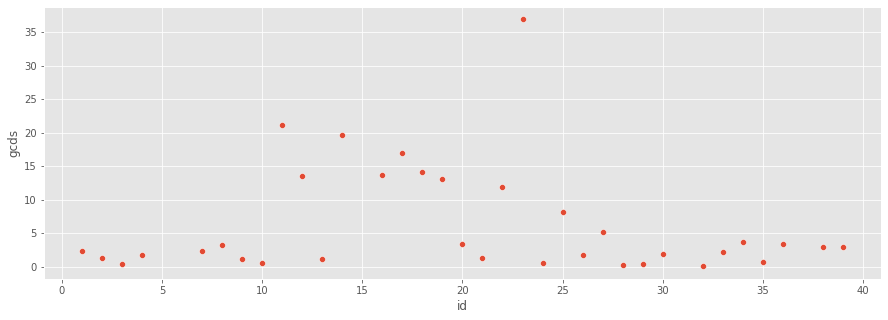

In [14]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,5))
sns.scatterplot(data=df, x="id", y='gcds')